# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
#from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import interp1d

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "output_sample"

In [ ]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [ ]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [ ]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = [1 if dat in ['Charged Off', 'Default'] else 0 for dat in data['loan_status']]

In [ ]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
nums = np.ones(len(data))
nums[:int(0.3*len(data))] = 0
np.random.shuffle(nums)
nums = nums.astype('int64').astype('bool')
data['train'] =nums

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters, cv=3, scoring='recall')
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [ ]:
## define your set of features to use in different models
your_features = [dat for dat in data.columns if dat not in ['id', 'outcome', 'train', 'loan_status']]
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Dummy Classifier  - Baseline ### 

  Model: Dummy Classifier
Fit time: 0.08 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.79175
              precision    recall  f1-score   support

  No default     0.7917    1.0000    0.8838     15835
     Default     0.0000    0.0000    0.0000      4165

    accuracy                         0.7917     20000
   macro avg     0.3959    0.5000    0.4419     20000
weighted avg     0.6269    0.7917    0.6997     20000



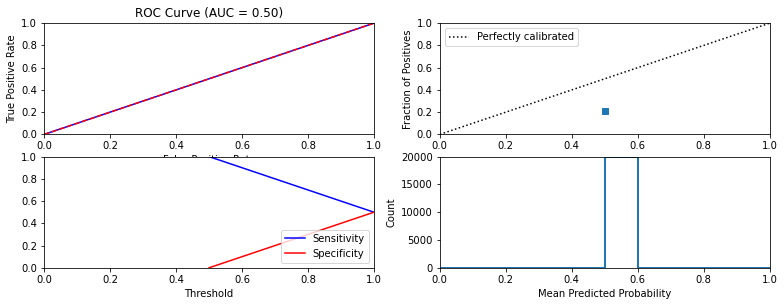


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.5022]


In [ ]:
## Train and test a random classifier

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="uniform")
dummyfit = fit_classification(dummy, data_dict, {}, 'Dummy Classifier' )

### Naive Bayes

  Model: Naive Bayes
Fit time: 0.45 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.79175
              precision    recall  f1-score   support

  No default     0.7917    1.0000    0.8838     15835
     Default     0.0000    0.0000    0.0000      4165

    accuracy                         0.7917     20000
   macro avg     0.3959    0.5000    0.4419     20000
weighted avg     0.6269    0.7917    0.6997     20000



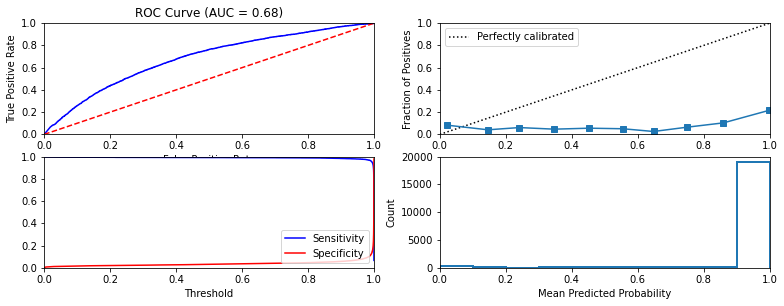


Similarity to LC grade ranking:  0.6500448381905671
Brier score: 0.7568943477722054
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.39996667]


In [ ]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, {}, 'Naive Bayes' )

### $l_1$ regularized logistic regression

  Model: L1 Logistic Regression
Fit time: 124.95 seconds
Optimal parameters:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.48528380888990746
Accuracy:  0.7953
              precision    recall  f1-score   support

  No default     0.8040    0.9805    0.8835     15835
     Default     0.5515    0.0912    0.1566      4165

    accuracy                         0.7953     20000
   macro avg     0.6778    0.5359    0.5200     20000
weighted avg     0.7514    0.7953    0.7321     20000



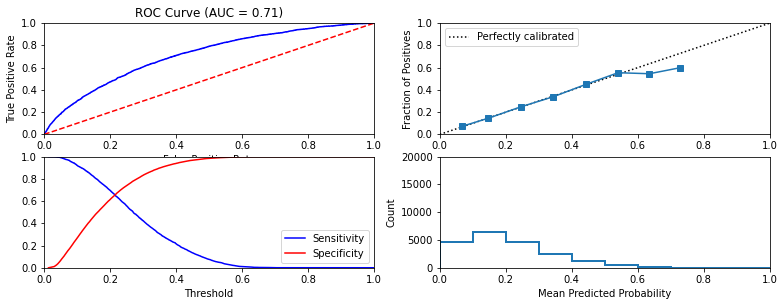


Similarity to LC grade ranking:  0.7277560068331338
Brier score: 0.1489765596304804
Were parameters on edge? : True
Score variations around CV search grid : 0.34016462287921106
[0.79196667 0.79103333 0.79313333 0.79373333 0.79373333 0.7937
 0.7937    ]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression()
cv_parameters = {'penalty':['l1'], 'C':[0.01, 0.1, 1, 10, 50, 100, 1000], 'solver':['liblinear']}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'L1 Logistic Regression')

### $l_2$ regularized logistic regression

  Model: L2 Logistic Regression
Fit time: 7.57 seconds
Optimal parameters:
{'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.4843147990652181
Accuracy:  0.79525
              precision    recall  f1-score   support

  No default     0.8041    0.9802    0.8835     15835
     Default     0.5501    0.0922    0.1579      4165

    accuracy                         0.7953     20000
   macro avg     0.6771    0.5362    0.5207     20000
weighted avg     0.7512    0.7953    0.7324     20000



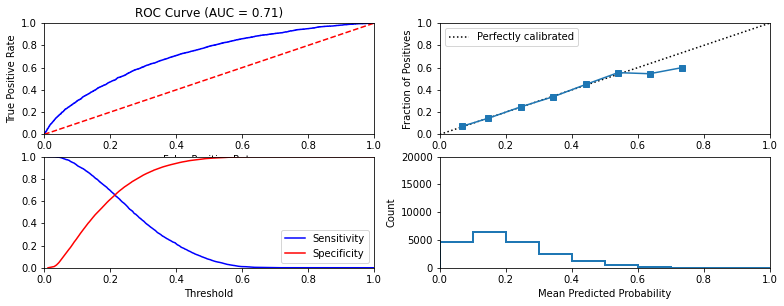


Similarity to LC grade ranking:  0.7277947005758917
Brier score: 0.14897948046388565
Were parameters on edge? : True
Score variations around CV search grid : 0.23097597849822474
[0.79293333 0.79296667 0.79233333 0.7919     0.7931     0.793
 0.7936     0.79346667 0.79373333 0.79356667 0.7937     0.79353333
 0.79366667 0.79346667]


In [ ]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression()
cv_parameters = {'penalty':['l2'], 'C':[0.01, 0.1, 1, 10, 50, 100, 1000], 'solver':['liblinear', 'lbfgs']}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'L2 Logistic Regression')

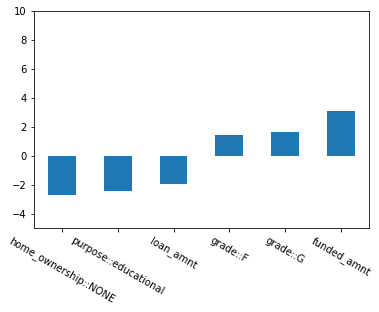

In [ ]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 21.14 seconds
Optimal parameters:
{'max_depth': 5, 'max_features': 0.2, 'min_samples_leaf': 1}

Accuracy-maximizing threshold was: 0.5295902883156297
Accuracy:  0.7913
              precision    recall  f1-score   support

  No default     0.7931    0.9964    0.8832     15835
     Default     0.4571    0.0115    0.0225      4165

    accuracy                         0.7913     20000
   macro avg     0.6251    0.5040    0.4528     20000
weighted avg     0.7231    0.7913    0.7039     20000



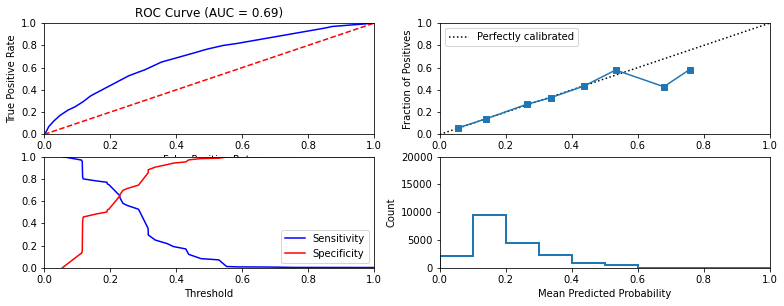


Similarity to LC grade ranking:  0.7645786621099958
Brier score: 0.15174742084623988
Were parameters on edge? : True
Score variations around CV search grid : 12.388524314319374
[0.69443333 0.7419     0.76533333 0.78       0.78256667 0.78296667
 0.6958     0.74403333 0.7647     0.77923333 0.77896667 0.78363333
 0.6971     0.72943333 0.75393333 0.7754     0.77953333 0.7812
 0.69423333 0.71863333 0.74946667 0.7662     0.7713     0.77896667
 0.69653333 0.7738     0.7844     0.78623333 0.78863333 0.78973333
 0.79186667 0.7914     0.7915     0.79163333 0.79163333 0.79163333
 0.7908     0.7915     0.791      0.79163333 0.79163333 0.79136667
 0.78966667 0.79076667 0.79153333 0.79163333 0.79116667 0.79156667
 0.79163333 0.79163333 0.79163333 0.79163333 0.79163333 0.79163333
 0.79163333 0.79166667 0.79166667 0.79163333 0.79173333 0.79163333
 0.79163333 0.7915     0.7916     0.7906     0.7906     0.79113333
 0.79163333 0.79106667 0.79126667 0.7917     0.79163333 0.792
 0.79173333 0.79126667 0.79

In [ ]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_features' : ["auto","sqrt", 0.2, 0.5, 2],
                 'min_samples_leaf' : [1, 5, 10, 20, 25, 30],
                 'max_depth' : [None, 3,4,5,10]
                }

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision Tree')

### Random forest

  Model: Random Forest
Fit time: 149.46 seconds
Optimal parameters:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3421647374991097
Accuracy:  0.77535
              precision    recall  f1-score   support

  No default     0.8307    0.8997    0.8638     15835
     Default     0.4425    0.3028    0.3595      4165

    accuracy                         0.7753     20000
   macro avg     0.6366    0.6012    0.6117     20000
weighted avg     0.7498    0.7753    0.7588     20000



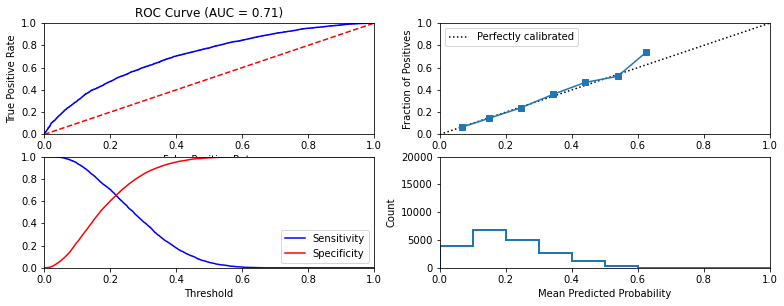


Similarity to LC grade ranking:  0.6545264193542932
Brier score: 0.14930235200977007
Were parameters on edge? : True
Score variations around CV search grid : 1.7130620985010638
[0.786      0.78983333 0.7915     0.79216667 0.79226667 0.7928
 0.792      0.7939     0.79346667 0.78296667 0.7869     0.7891
 0.78756667 0.78916667 0.79193333 0.78956667 0.79176667 0.79293333
 0.7916     0.79163333 0.79163333 0.79163333 0.79163333 0.79163333
 0.79166667 0.79163333 0.79163333 0.7932     0.79316667 0.7928
 0.7921     0.7928     0.7934     0.79243333 0.79333333 0.79286667
 0.79306667 0.79196667 0.79313333 0.79253333 0.79276667 0.79343333
 0.79286667 0.79246667 0.7937     0.78933333 0.79196667 0.79366667
 0.7909     0.793      0.79336667 0.79136667 0.7928     0.7934
 0.7873     0.79166667 0.7934     0.79083333 0.79263333 0.79303333
 0.79373333 0.79263333 0.79366667 0.7803     0.78833333 0.78976667
 0.78863333 0.79003333 0.79096667 0.79126667 0.7919     0.79173333]


In [ ]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(n_jobs=-1)
cv_parameters = {'max_features' : ["auto", 0.5],
                'min_samples_leaf' : [1, 5, 10],
                'n_estimators': [20, 50, 100],
                'max_depth' : [None, 5, 10, 20]
                }

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random Forest')

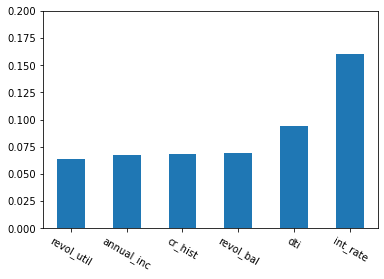

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer Perceptron
Fit time: 389.0 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (16, 8), 'learning_rate_init': 0.1, 'max_iter': 300, 'solver': 'sgd'}

Accuracy-maximizing threshold was: 0.4759678133478346
Accuracy:  0.79645
              precision    recall  f1-score   support

  No default     0.8027    0.9851    0.8846     15835
     Default     0.5830    0.0792    0.1395      4165

    accuracy                         0.7964     20000
   macro avg     0.6929    0.5322    0.5120     20000
weighted avg     0.7569    0.7964    0.7294     20000



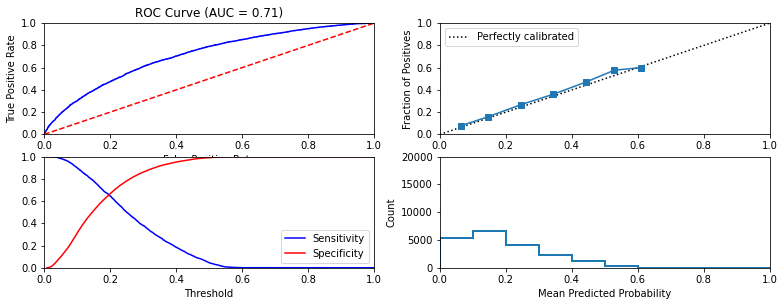


Similarity to LC grade ranking:  0.7131042667432866
Brier score: 0.14911392773183701
Were parameters on edge? : True
Score variations around CV search grid : 1.751880015124147
[0.7915     0.78246667 0.7927     0.78113333 0.79216667 0.7827
 0.792      0.78416667 0.79333333 0.78393333 0.79153333 0.78936667
 0.79243333 0.78223333 0.79323333 0.78073333 0.79123333 0.784
 0.7928     0.78113333 0.79143333 0.78363333 0.79343333 0.77953333]


In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes' : [(16,),(16,8)],
                 'activation' : ["logistic"],
                 'solver' :['sgd', 'adam'],
                 'learning_rate_init' : [0.01, 0.05, 0.1],
                 'max_iter' : [200, 300]
                }

mlp = fit_classification(mlp, data_dict, cv_parameters, "Multi-layer Perceptron")

## Train and Test logistic regression model with features derived by LendingClub

  Model: L1 Logistic - Derived Features
Fit time: 0.1 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.6858290864591542
Accuracy:  0.79175
              precision    recall  f1-score   support

  No default     0.7917    1.0000    0.8838     15835
     Default     0.0000    0.0000    0.0000      4165

    accuracy                         0.7917     20000
   macro avg     0.3959    0.5000    0.4419     20000
weighted avg     0.6269    0.7917    0.6997     20000



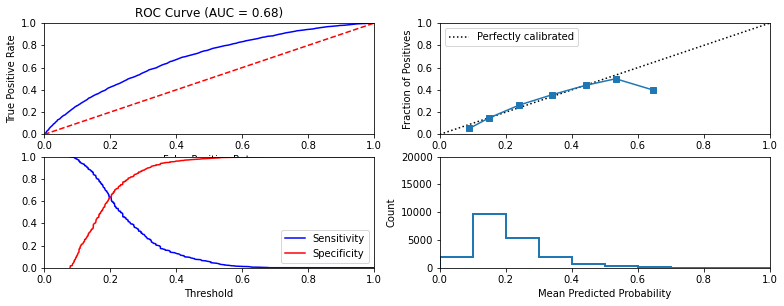


Similarity to LC grade ranking:  0.8573178535623209
Brier score: 0.1540372910021165
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.7872]


In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['int_rate']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)

lc1_only_logistic = fit_classification(l1_logistic['model'], data_dict, {}, "L1 Logistic - Derived Features")

  Model: L2 Logistic - Derived Features
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.6859992521246314
Accuracy:  0.79175
              precision    recall  f1-score   support

  No default     0.7917    1.0000    0.8838     15835
     Default     0.0000    0.0000    0.0000      4165

    accuracy                         0.7917     20000
   macro avg     0.3959    0.5000    0.4419     20000
weighted avg     0.6269    0.7917    0.6997     20000



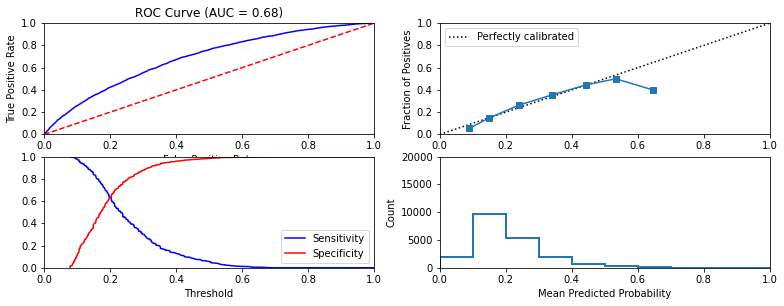


Similarity to LC grade ranking:  0.8573178535623209
Brier score: 0.15403748373943368
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.7872]


In [ ]:
## train a l2-regularized logistic regression model on data with only that feature

lc2_only_logistic = fit_classification(l2_logistic['model'], data_dict, {}, "L2 Logistic - Derived Features")

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [ ]:
from sklearn.metrics import recall_score

your_features = [dat for dat in data.columns if dat not in ['int_rate', 'grade', 'id', 'outcome', 'train', 'loan_status']]


list_models = [dummyfit['model'], gnb['model'],l1_logistic['model'], l2_logistic['model'],
               decision_tree['model'], random_forest['model'], mlp['model']]

seed = np.arange(0,100)

from tqdm.notebook import tqdm_notebook
 
for j in tqdm_notebook(range(len(list_models)),desc = 'Model Loop'):
    scores = []
    for i in tqdm_notebook(seed, desc='Seed loop'):
        default_seed = i
        np.random.seed(default_seed)
        nums = np.ones(len(data))
        nums[:int(0.3*len(data))] = 0
        np.random.shuffle(nums)
        nums = nums.astype('int64').astype('bool')
        data['train'] =nums
        #temp = np.random.choice(len(data), int(0.7*len(data)))
        #data['train'] = [True if dat in temp else False for dat in range(len(data))]
        data_dict = prepare_data(feature_subset = your_features, random_state=default_seed)
        y_test = data_dict['y_test']
        model_fit = fit_classification(list_models[j], data_dict, {},"x", random_state=default_seed, output_to_file=False, print_to_screen=False)
        y_pred = model_fit['y_pred_labels']
        recall_scores = recall_score(y_test, y_pred)
        scores.append(recall_scores)
    print("=========================================================")
    print("  Model: ", type(list_models[j]).__name__ )
    print("=========================================================")
    print( np.mean(scores), np.std(scores))
        


Model Loop:   0%|          | 0/7 [00:00<?, ?it/s]

Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  DummyClassifier
0.0 0.0


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  GaussianNB
0.0007212775608722101 0.0016979865683210886


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  LogisticRegression
0.06288588217494033 0.021137086362673432


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  LogisticRegression
0.06192062881536952 0.020394454815538903


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  DecisionTreeClassifier
0.0036235411807673317 0.007454153271005278


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  RandomForestClassifier
0.28721591813125597 0.01997756535204808


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Model:  MLPClassifier
0.05972050897080899 0.020079401335574242


## YOURMODEL vs LendingClub ##

In [ ]:
YOURMODEL = random_forest

data_dict = prepare_data(feature_subset = your_features)
y_test = data_dict['y_test']
test_data = data[data_dict['test_set']]
random_forest_fit = fit_classification(YOURMODEL['model'], data_dict, {},"x", output_to_file=False, print_to_screen=False)
test_data['label'] = random_forest_fit['y_pred_labels']
test_data_grade = test_data.groupby(by = ['grade','label']).count()
test_data_grade["id"]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0

grade  label
A      False    3548
B      False    5822
       True       41
C      False    5311
       True      258
D      False    2633
       True      377
E      False    1009
       True      399
F      False     287
       True      184
G      False      71
       True       60
Name: id, dtype: int64

## Time stability test of YOURMODEL

In [ ]:
len(data[(data['issue_d']>=datetime.date(2010, 1, 1)) & (data['issue_d']<=datetime.date(2010,12,31))])

10613

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0

  Model: Random Forest - 2010 data
Fit time: 0.52 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.267282620026478
Accuracy:  0.837
              precision    recall  f1-score   support

  No default     0.8720    0.9505    0.9096      2587
     Default     0.2889    0.1259    0.1754       413

    accuracy                         0.8370      3000
   macro avg     0.5804    0.5382    0.5425      3000
weighted avg     0.7917    0.8370    0.8085      3000



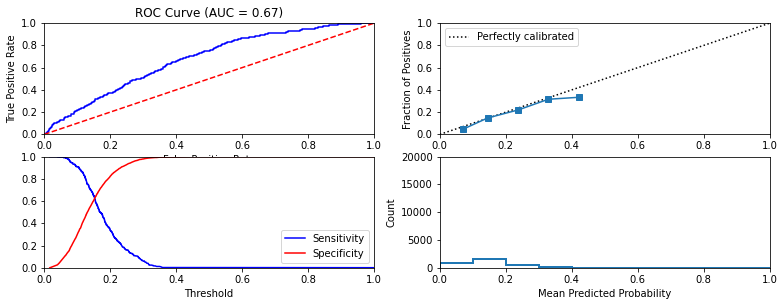


Similarity to LC grade ranking:  0.5618069533893831
Brier score: 0.11379325552714196
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.87279999]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0

  Model: Random Forest - 2016 data
Fit time: 0.45 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.36071190363644184
Accuracy:  0.7976666666666666
              precision    recall  f1-score   support

  No default     0.8754    0.8868    0.8811      2535
     Default     0.3356    0.3118    0.3233       465

    accuracy                         0.7977      3000
   macro avg     0.6055    0.5993    0.6022      3000
weighted avg     0.7917    0.7977    0.7946      3000



[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


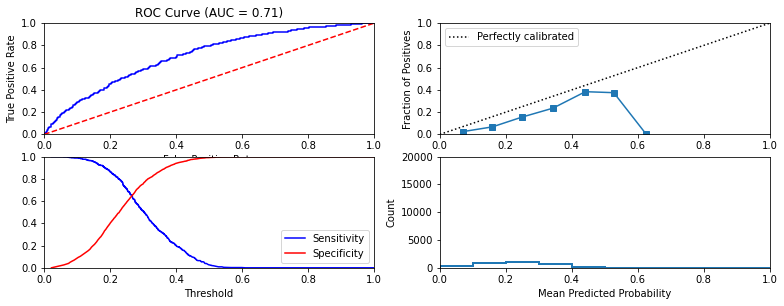


Similarity to LC grade ranking:  0.4208850621246755
Brier score: 0.13021072998338895
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.73919898]


In [ ]:
## Define the time window of your train and test data - 2010
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2010, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 5000, n_samples_test = 3000, feature_subset = your_features)


## Train and test YOURMODEL using this data 
cv_parameters = {}

YM_2010 = fit_classification(YOURMODEL['model'], data_dict_test, cv_parameters, "Random Forest - 2010 data")

## Define the time window of your train and test data - 2016
start_date_train = datetime.date(2016, 1, 1)
end_date_train = datetime.date(2016, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 5000, n_samples_test = 3000, feature_subset = your_features)


## Train and test YOURMODEL using this data
cv_parameters = {}

YM_2016 = fit_classification(YOURMODEL['model'], data_dict_test, cv_parameters, "Random Forest - 2016 data")

## Train and test YOURMODEL on the original data

In [ ]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False
    
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas data_csframe. It will return a dictionary containing
    these data_csframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and only those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read without formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory+"/"
    
    all_files = [f for f in listdir(directory) if isfile(join(directory, f))] # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i,skiprows=1,dtype='str') # read each with dtype='str' and skip_rows =1
        df=output[i]
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = np.array([0 if is_integer(id) else 1 for id in df["id"]]) # mask rows that have non-integer IDs. Use is_integer method
        
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = df[~invalid_rows.astype(bool)] # remove invalid rows
    
    return output # return dictionary of data_csframe

In [ ]:
from os import listdir
from os.path import isfile, join


dir_cs = "./case_study_data/2003_download/"

pickle_file = dir_cs # path to save cleaned data_cs

files_cs = ingest_files(dir_cs) # dictionary of (filename, data_csframe) as (key, value)

#data_cs_og=data_cs.copy()

data_cs = pd.concat([value for value in files_cs.values()]) # combine "files_cs" into a pandas data_csframe
data_cs.head()
data_cs.reset_index(drop=True)             # resent index with drop = True

n_rows = len(data_cs)
data_cs=data_cs[data_cs["loan_status"].isin(["Fully Paid","Charged Off","Default"])]
print("Removed " + str(n_rows - len(data_cs)) + " rows")

n_rows = len(data_cs)
data_cs = data_cs[data_cs["issue_d"].astype(str)>="2010-01-01"]

print("Removed " + str(n_rows - len(data_cs)) + " rows")

nums = np.ones(len(data_cs))
nums[:int(0.3*len(data_cs))] = 0
np.random.shuffle(nums)
nums = nums.astype('int64').astype('bool')
data_cs['train'] =nums

data_cs["outcome"] = [1 if dat in ['Charged Off', 'Default'] else 0 for dat in data_cs['loan_status']]

Directory ./case_study_data/2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Fo

In [ ]:
## define your set of features to use in different models
feature_set = ["id", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate",
"installment", "grade", "sub_grade", "emp_length", "home_ownership",
"annual_inc", "verification_status", "issue_d", "loan_status", "purpose", "addr_state", "dti", "total_pymnt", "delinq_2yrs", "earliest_cr_line",
"open_acc", "pub_rec", "last_pymnt_d", "last_pymnt_amnt", "fico_range_high",
"fico_range_low", "last_fico_range_high", "last_fico_range_low",
"application_type", "revol_bal", "revol_util", "recoveries","zip_code","emp_title","title"]

# prepare the train, test data_cs for training models
float_cols_cs = ["loan_amnt","funded_amnt","funded_amnt_inv","annual_inc","installment","dti","delinq_2yrs","open_acc","pub_rec","fico_range_high",
              "fico_range_low","revol_bal","total_pymnt","recoveries","last_pymnt_amnt","last_fico_range_high","last_fico_range_low"]
cat_cols_cs = ["term","grade","sub_grade","verification_status","emp_length","home_ownership","loan_status","purpose",
            "addr_state","application_type"] # categorical features
perc_cols_cs = ['int_rate', 'revol_util']
date_cols_cs = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

discrete_features_cs = list(set(cat_cols_cs) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features_cs = list(float_cols_cs + perc_cols_cs)

# data_cs, discrete_features_cs, continuous_features_cs, ret_cols = pickle.load( open( "clean_data_cs.pickle", "rb" ) )

# Ensure that we have types for every column
#assert set(feature_set) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [ ]:
for i in float_cols_cs:
    data_cs[i] = data_cs[i].astype(float) # typecast float columns

In [ ]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols_cs:
    #print(i)
    data_cs[i] = [clean_perc(x) for x in data_cs[i]] # apply clean_perc to percentage columns

In [ ]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols_cs:
    data_cs[i] = [clean_date(d) for d in data_cs[i]] # typecast date cloumns to data_cstime using clean_date

In [ ]:
# Deal with null values. We allow cateogrical variables to be null


required_cols_cs = set(feature_set) - set(cat_cols_cs) - set(["id"])
required_cols_cs.add("loan_status")

n_rows = len(data_cs)

data_cs.dropna(inplace=True,subset=required_cols_cs) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(data_cs)) + " rows")

Removed 92280 rows


In [ ]:
for i in cat_cols_cs:
    data_cs[i]=data_cs[i].where(pd.notnull(data_cs[i]),None) # for categorical features if the value is null/empty set it to None

In [ ]:
# We remove features like "emp_title","title","zip_code" are also removed because of the high number 
#of unique alues each of these features have.
your_features_Q6 = [dat for dat in feature_set if dat not in ['id','outcome', 'train','loan_status','emp_title','title','zip_code']]
#your_features = [dat for dat in feature_set if dat not in ['id','outcome', 'train','loan_status','zip_code']]

# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous_cs = data_cs[continuous_features_cs].values

X_discrete_cs = pd.get_dummies(data_cs[discrete_features_cs], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_cs_dummies = X_discrete_cs.columns.tolist()
X_discrete_cs = X_discrete_cs.values

X_cs = np.concatenate( (X_continuous_cs, X_discrete_cs), axis = 1 )

y_cs = data_cs.outcome.values

train_cs = data_cs.train.values

In [ ]:
#data_cs.head()

In [ ]:
default_seed=42
def prepare_data_new(data_subset = np.array([True]*len(data_cs)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data_cs.issue_d.min(), data_cs.issue_d.max()),
                    date_range_test = (data_cs.issue_d.min(), data_cs.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train_cs & (data_cs.issue_d >= date_range_train[0]) &
                            (data_cs.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train_cs == False) & (data_cs.issue_d >= date_range_test[0])
                            & (data_cs.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X_cs[ filter_train , :]
    X_test = X_cs[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features_cs + discrete_features_cs_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y_cs[ filter_train ]
    y_test = y_cs[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [ ]:
def fit_classification_new(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters, cv=3)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data_cs.loan_status[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
#     # Output results to file
#     # ----------------------
#     if probs_predicted and output_to_file:
#         # Check whether any of the CV parameters are on the edge of
#         # the search space
#         opt_params_on_edge = find_opt_params_on_edge(cv_model)
#         dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
#         if print_to_screen:
#             print("Were parameters on edge? : " + str(opt_params_on_edge))
        
#         # Find out how different the scores are for the different values
#         # tested for by cross-validation. If they're not too different, then
#         # even if the parameters are off the edge of the search grid, we should
#         # be ok
#         score_variation = find_score_variation(cv_model)
#         dump_to_output(model_name + "::score_variation", score_variation)
#         if print_to_screen:
#             print("Score variations around CV search grid : " + str(score_variation))
        
#         # Print out all the scores
#         dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
#         if print_to_screen:
#             print( str(cv_model.cv_results_['mean_test_score']) )
        
#         # Dump the AUC to file
#         dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [ ]:
data_dict = prepare_data_new(feature_subset = your_features_Q6)

all_features = pd.Series(continuous_features_cs + discrete_features_cs)
idx = [i for i, j in enumerate(continuous_features_cs + discrete_features_cs)
                                                     if j.split("::")[0] in your_features_Q6]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent work

  Model: Random Forest
Fit time: 4.76 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5343966535897462
Accuracy:  0.9829
              precision    recall  f1-score   support

  No default     0.9839    0.9949    0.9894     16003
     Default     0.9788    0.9347    0.9562      3997

    accuracy                         0.9829     20000
   macro avg     0.9813    0.9648    0.9728     20000
weighted avg     0.9829    0.9829    0.9828     20000



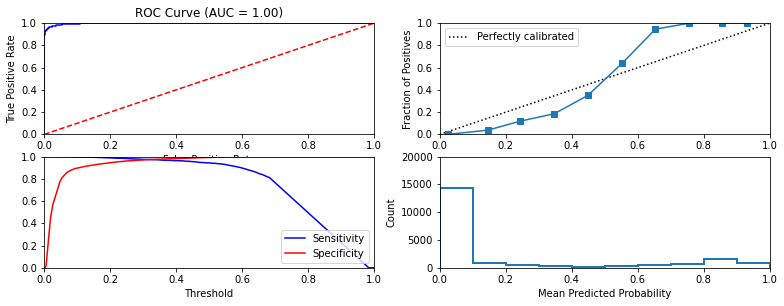


Similarity to LC grade ranking:  -0.5588544446340303
Brier score: 0.021307011441547553


In [ ]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(n_jobs=-1, verbose=True,max_features = "auto",min_samples_leaf = 5, n_estimators = 50, max_depth = 10)
random_forest = fit_classification_new(random_forest, data_dict, {}, 'Random Forest')

## Test regression models

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [ ]:
your_features = [dat for dat in data.columns if dat not in ['int_rate', 'grade', 'id', 'outcome', 'train', 'loan_status']]

data_dict = prepare_data(feature_subset = your_features)

### $l_1$ regularized linear regression

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters

lasso = linear_model.Lasso()

cv_parameters = {'alpha': np.logspace(-3, 3, 7),
                 'max_iter': [50, 100, 150, 200, 500]}

reg_lasso = fit_regression(lasso, data_dict, cv_parameters, False, "Lasso Regression - All Returns")

  Model: Lasso Regression - All Returns  Return column: ret_PESS
Fit time: 5.97 seconds
Optimal parameters:
{'alpha': 0.001, 'max_iter': 50}

Testing r2 score: 0.014717952370765564
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -10.283462088906163
All test scores : [-0.10036624 -0.10036624 -0.10036624 -0.10036624 -0.10036624 -0.11068736
 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736
 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736
 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736
 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736
 -0.11068736 -0.11068736 -0.11068736 -0.11068736 -0.11068736]
  Model: Lasso Regression - All Returns  Return column: ret_OPT
Fit time: 6.39 seconds
Optimal parameters:
{'alpha': 0.001, 'max_iter': 50}

Testing r2 score: 0.00696686470803598
Were parameters on edge (model) : True
Score variations around CV search grid (model) :

### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

ridge = linear_model.Ridge()

cv_parameters = {'alpha': np.logspace(-3, 3, 4),
                 'max_iter': [50, 100, 150, 200, 500],
                 'solver':['auto', 'saga']}

reg_ridge = fit_regression(ridge, data_dict, cv_parameters, False, "Ridge Regression - All Returns")

  Model: Ridge Regression - All Returns  Return column: ret_PESS
Fit time: 93.5 seconds
Optimal parameters:
{'alpha': 10.0, 'max_iter': 200, 'solver': 'saga'}

Testing r2 score: 0.028734414273005715
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -6.385320659129626
All test scores : [-0.08743875 -0.08743594 -0.08743875 -0.08743346 -0.08743875 -0.08741005
 -0.08743875 -0.08743791 -0.08743875 -0.08743875 -0.08742727 -0.0874356
 -0.08742727 -0.08742732 -0.08742727 -0.08742311 -0.08742727 -0.08742677
 -0.08742727 -0.08742747 -0.08710399 -0.0871038  -0.08710399 -0.08710405
 -0.08710399 -0.08710874 -0.08710399 -0.08709795 -0.08710399 -0.08710296
 -0.09265683 -0.09265655 -0.09265683 -0.09264929 -0.09265683 -0.09265854
 -0.09265683 -0.09265789 -0.09265683 -0.09265943]
  Model: Ridge Regression - All Returns  Return column: ret_OPT
Fit time: 77.84 seconds
Optimal parameters:
{'alpha': 1000.0, 'max_iter': 200, 'solver': 'saga'}

Testing r2 score: 0.0109649

KeyboardInterrupt: 

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters

mlp_reg = MLPRegressor()

cv_parameters = {'hidden_layer_sizes' : [(16,),(16,8)],
                 'activation' : ["logistic"],
                 'solver' :['sgd', 'adam'],
                 'learning_rate_init' : [0.01, 0.05, 0.1],
                 'max_iter' : [200, 300],
                 'alpha': np.logspace(-3, 3, 4)}

reg_mlp = fit_regression(mlp_reg, data_dict, cv_parameters, False, 'Multi-layer Perceptron - All returns')

  Model: Multi-layer Perceptron - All returns  Return column: ret_PESS
Fit time: 290.47 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'adam'}

Testing r2 score: -0.000737499932709218
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -713.2986116740622
All test scores : [-0.13925314 -0.06876381 -0.13034759 -0.12927153 -0.12524161 -0.08713007
 -0.0934743  -0.10112664 -0.06460821 -0.07247558 -0.09301974 -0.10289352
 -0.11555091 -0.10691054 -0.10474894 -0.08844584 -0.10467711 -0.1300031
 -0.1231215  -0.04279452 -0.08414385 -0.0679218  -0.12423451 -0.08211675
 -0.12037733 -0.03242095 -0.10819617 -0.13505437 -0.064702   -0.13823457
 -0.10584996 -0.14674587 -0.11395435 -0.14538982 -0.10715612 -0.20482072
 -0.1270317  -0.11379999 -0.11564895 -0.05423948 -0.12307972 -0.0645611
 -0.10738796 -0.12728233 -0.12514789 -0.14150831 -0.12871865 -0.18732081
 -0

### Random forest regressor

In [ ]:
## trying random forest regression with hyper-parameters

rfr = RandomForestRegressor()

cv_parameters = {'max_features' : ["auto", 0.5, 0.75],
                'min_samples_leaf' : [5, 10, 20],
                'n_estimators': [20, 50, 100],
                'max_depth' : [5, 10]}

reg_rf = fit_regression(rfr, data_dict, cv_parameters, False, 'Random Forest Regressor - All Returns ')

  Model: Random Forest Regressor - All Returns   Return column: ret_PESS
Fit time: 12012.89 seconds
Optimal parameters:
{'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 20, 'n_estimators': 100}

Testing r2 score: 0.038462819830476724
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -11.114671850569632
All test scores : [-0.09353366 -0.09320877 -0.09268853 -0.09409173 -0.09404069 -0.09278915
 -0.09448593 -0.09291755 -0.09282951 -0.092915   -0.09219202 -0.09184175
 -0.0928992  -0.09335987 -0.09247993 -0.09358459 -0.09243119 -0.09221395
 -0.09348939 -0.09303582 -0.09248126 -0.09320244 -0.09293456 -0.09256529
 -0.09479863 -0.09248963 -0.09281403 -0.09367901 -0.09082337 -0.08755715
 -0.09325314 -0.09008809 -0.08902123 -0.09401653 -0.08804381 -0.08841478
 -0.09141244 -0.08897385 -0.08563357 -0.09082733 -0.08754978 -0.0867912
 -0.09129671 -0.08778204 -0.08531603 -0.09280997 -0.0878743  -0.08731042
 -0.09253236 -0.08767076 -0.08824645 -0.0908588

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.sample(n=num_loans)

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[colname].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[colname].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [ ]:
YOURREGRESSOR = 

cv_parameters = {}

YOURREGRESSOR_Separate = fit_regression(YOURREGRESSOR, data_dict, cv_parameters, True, 'Best Regressor - Separate' )

{'model': RandomForestClassifier(min_samples_leaf=10, n_estimators=50, n_jobs=-1),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.11521507, 0.08579748, 0.28170197, ..., 0.1048415 , 0.07370827,
        0.17086904])}

In [ ]:
## Test investment strategies using the best performing regressor

list_strategy = ['Random', 'Default-based', 'Return-based', 'Default-return-based' ]
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

seed = np.arange(0,100)

for j in tqdm_notebook(list_strategy ,desc = 'Strategy Loop'):
    scores =  {k: [] for k in col_list}
    for i in tqdm_notebook(seed, desc='Seed loop'):
        default_seed = i
        np.random.seed(default_seed)
        nums = np.ones(len(data))
        nums[:int(0.3*len(data))] = 0
        np.random.shuffle(nums)
        nums = nums.astype('int64').astype('bool')
        data['train'] =nums
        data_dict = prepare_data(feature_subset = your_features, random_state=default_seed)
        if j == 'Default-return-based':
            strat_return = test_investments(data_dict, YOURMODEL, YOURREGRESSOR_Separate, j, 1000, default_seed, False)
        else: 
            strat_return = test_investments(data_dict, YOURMODEL, YOURREGRESSOR, j, 1000, default_seed, False)
        for ret_col in col_list:
            #print(strat_return[ret_col]['average return'])
            scores[ret_col].append(strat_return[ret_col]['average return'])
    print("=========================================================")
    print("Strategy: ", j)
    for ret_col in col_list:
        print(ret_col, " : ", str(np.mean(scores[ret_col]))) 
    print("=========================================================")


Strategy Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Strategy:  Random
ret_PESS  :  0.002523683305987975
ret_OPT  :  0.050431242013785404
ret_INTa  :  0.4317002100564393
ret_INTb  :  1.2854802046451124


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Strategy:  Default-based
ret_PESS  :  0.0029047292150194554
ret_OPT  :  0.05084959979846824
ret_INTa  :  0.4317613775710004
ret_INTb  :  1.2867832015882268


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Strategy:  Return-based
ret_PESS  :  0.010860528045907434
ret_OPT  :  0.06333358403188458
ret_INTa  :  0.47715489964819935
ret_INTb  :  1.4542488229477224


Seed loop:   0%|          | 0/100 [00:00<?, ?it/s]

  Strategy:  Default-return-based
ret_PESS  :  0.03713684531852536
ret_OPT  :  0.1250916686476973
ret_INTa  :  0.5216469950794899
ret_INTb  :  1.5165240313650017


In [ ]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)  
strat_rand = test_investments(data_dict, YOURMODEL, reg_lasso, test_strategy)

for ret_col in col_list:
    print(ret_col+ ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.0029795052449895073
ret_OPT: 0.05078000635363158
ret_INTa: 0.43634426116385944
ret_INTb: 1.2892539427334087


In [ ]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_rand = test_investments(data_dict, random_forest, reg_lasso, test_strategy)

for ret_col in col_list:
    print(ret_col+ ': ' + str(strat_rand[ret_col]['average return']))


strategy: Default-based
ret_PESS: 0.007548985022816049
ret_OPT: 0.04249145107768116
ret_INTa: 0.4338374072966351
ret_INTb: 1.2832280799822677


In [ ]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_rand = test_investments(data_dict, random_forest, reg_lasso, test_strategy)

for ret_col in col_list:
    print(ret_col+ ': ' + str(strat_rand[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.010860528045907432
ret_OPT: 0.06333358403188458
ret_INTa: 0.4771548996481995
ret_INTb: 1.4542488229477217


In [ ]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
#cv_parameters = ...

#reg_separate = fit_regression(...)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict, random_forest, reg_ridge_separate, test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based
ret_PESS: 0.04458078172602782
ret_OPT: 0.1375509959848882
ret_INTa: 0.5332135640712066
ret_INTb: 1.5473426436618773


In [ ]:
from tabulate import tabulate
 
# assign data
mydata = [
           ["Random", accuracy_pretained, "-"],
           ["Default", accuracy_train_5NN, accuracy_bottleneck_5NN],
           ["Return Based", accuracy_train_RFC, accuracy_bottleneck_RFC],
           ["Default-Return Based", accuracy_pretained, "-"],]
 
# create header
head = ["Model Type", "Raw Features", "Bottleneck Features"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

In [ ]:
default_seed=1

## Sensitivity test of portfolio size

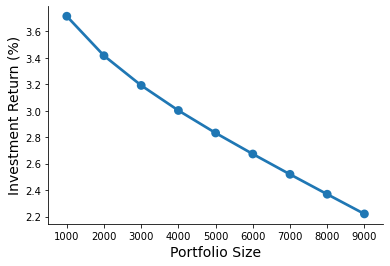

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, YOURMODEL, YOURREGRESSOR_Separate, j, num_loans, default_seed, False)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()